In [1]:
import json
import re
import os
from pathlib import Path

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
import torch
import torchvision.transforms.functional as TF
from einops import rearrange

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [25]:
import mushroom.utils as utils
from mushroom.registration import read_bigwarp_warp_field, register_adata, register_codex, warp_pts, warp_image
from mushroom.dataloaders import incorporate_hi_res

In [7]:
run_dir = '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/'
out_dir = os.path.join(run_dir, 'registered')


In [8]:
metadata = json.load(open(os.path.join(run_dir, 'slices_unregistered', 'metadata.json')))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31']}

In [9]:
channel_to_image = utils.extract_ome_tiff(
    '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff',
    channels=['DAPI', 'Pan-Cytokeratin']
)
channel_to_image.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


dict_keys(['DAPI', 'Pan-Cytokeratin'])

In [10]:
a = sc.read_h5ad('/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_4/HT397B1_U12_03172023.h5ad')
a

AnnData object with n_obs × n_vars = 109677 × 28
    obs: 'row', 'col', 'bbox-r1', 'bbox-r2', 'bbox-c1', 'bbox-c2', 'area', 'DAPI_intensity', 'CD8_intensity', 'Her2 (D)_intensity', 'GATA3 (D)_intensity', 'cKIT-(D)_intensity', 'Pan-Cytokeratin_intensity', 'GLUT1-(D)_intensity', 'Podoplanin_intensity', 'CD68 (D)_intensity', 'HLA-DR_intensity', 'Keratin 14_intensity', 'FoxP3_intensity', 'MGP-(D)_intensity', 'E-cadherin_intensity', 'SMA-(D)_intensity', 'CD3e_intensity', 'Ki67_intensity', 'Vimentin-(D)_intensity', 'CD11b_intensity', 'PR-(D)_intensity', 'Bap1 (D)_intensity', 'CD45 (D)_intensity', 'ER_intensity', 'CD31_intensity', 'COX6c (D)_intensity', 'CK19_intensity', 'PLAT/tPA (D)_intensity', 'sample', 'name', 'CD20-(D)_intensity', 'cell_type', 'omero_dataset', 'omero_image'
    uns: 'gating_strategy', 'thresholds'
    obsm: 'spatial'

In [11]:
ddf = read_bigwarp_warp_field(
    '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/ddfs/s2.tiff',
    metadata['downsample_scaler']
)

In [12]:
img = channel_to_image['DAPI']

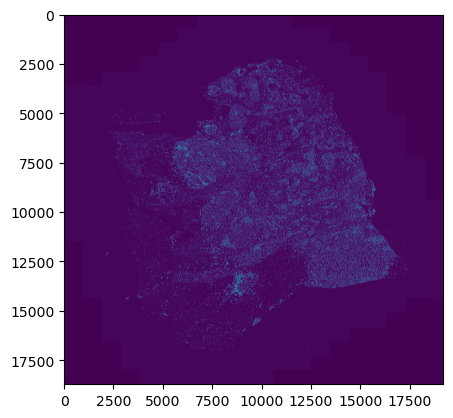

In [13]:
plt.imshow(img)

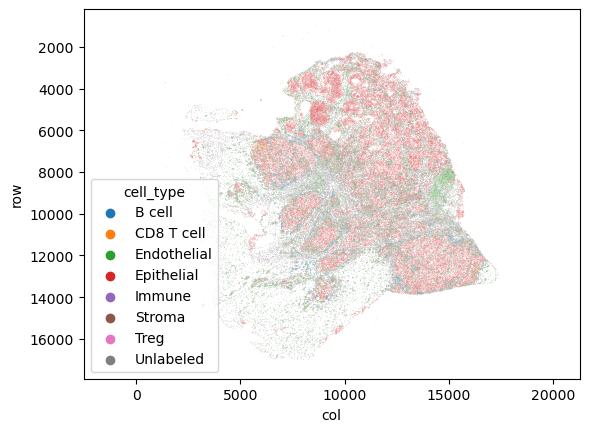

In [14]:
sns.scatterplot(data=a.obs, x='col', y='row', hue='cell_type', s=.1)
plt.axis('equal')
plt.gca().invert_yaxis()

In [15]:
warped_channel_to_image = register_codex(channel_to_image, ddf)

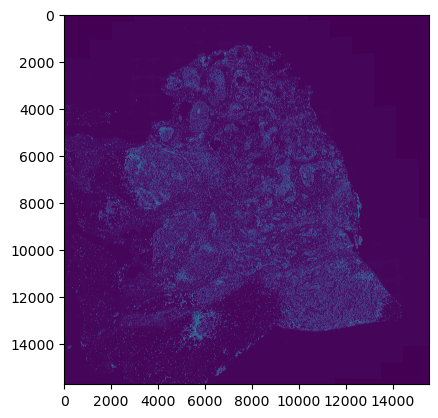

In [16]:
plt.imshow(warped_channel_to_image['DAPI'])

In [17]:
ddf.shape

torch.Size([2, 15730, 15510])

In [18]:
pts = a.obs[['row', 'col']].values
pts

array([[  994,  8658],
       [ 1196,  9230],
       [ 1298,  8198],
       ...,
       [16973,  8008],
       [16994,  7753],
       [17102, 11774]])

In [38]:
pts_warped, mask = warp_pts(pts, ddf)

tensor([False,  True,  True,  ..., False, False, False])


In [39]:
pts_warped

tensor([[  119,  6326],
        [  215,  5331],
        [  308,  5808],
        ...,
        [15720,  5715],
        [15717,  5754],
        [15727,  6000]])

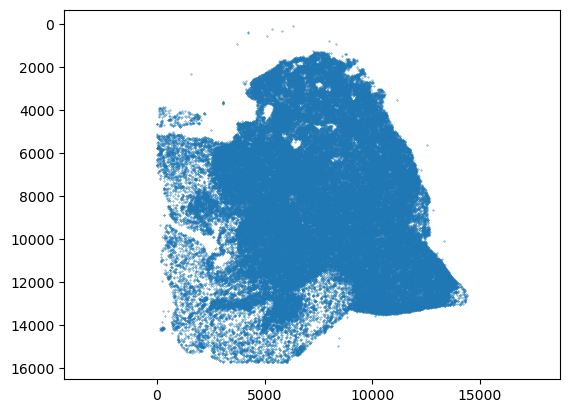

In [40]:
plt.scatter(pts_warped[:, 1], pts_warped[:, 0], s=.1)
plt.axis('equal')
plt.gca().invert_yaxis()

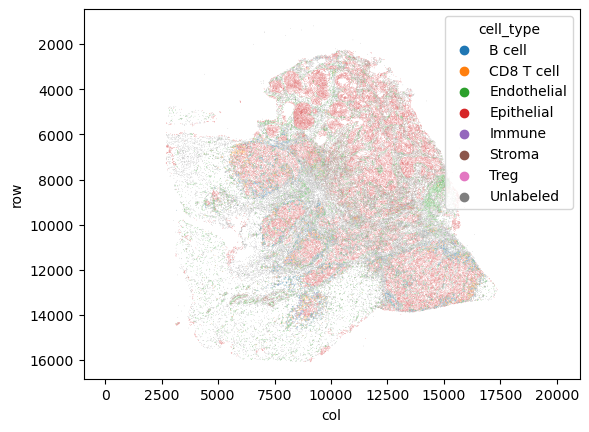

In [41]:
sns.scatterplot(data=a[mask.numpy()].obs, x='col', y='row', hue='cell_type', s=.1)
plt.axis('equal')
plt.gca().invert_yaxis()

In [23]:
from scipy import ndimage as ndi


In [26]:
img = torch.zeros((ddf.shape[-2], ddf.shape[-1]), dtype=torch.long)
mask = torch.ones((pts.shape[0],), dtype=torch.bool)
kept_idxs = []
for i, (r, c) in enumerate(pts):
    if r >= img.shape[-2] or c >= img.shape[-1]:
        mask[i] = False
    else:
        img[r, c] = i + 1
        kept_idxs.append(i)


img = warp_image(img, ddf)

objects = ndi.find_objects(img.numpy())

In [29]:
pts.max(axis=0)

array([17102, 17361])

In [28]:
len(objects)

108916

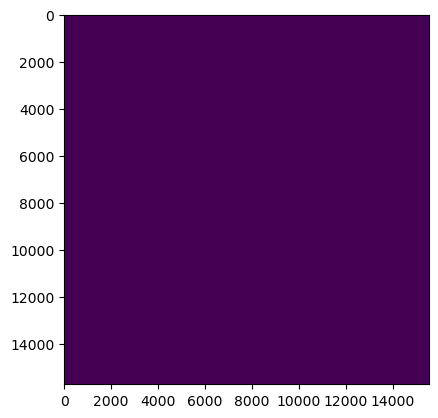

In [27]:
plt.imshow(img)